In [2]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from torch.optim.lr_scheduler import StepLR
import time
import torch.nn as nn
from datetime import datetime

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter()
])

full_dataset = datasets.ImageFolder('/kaggle/input/class-30/mammals', transform=transform)
class_counts = {class_name: 0 for class_name in full_dataset.classes}
for _, index in full_dataset.samples:
    class_name = full_dataset.classes[index]
    class_counts[class_name] += 1
print("Total number of classes:", len(full_dataset.classes))
print("Class names:", full_dataset.classes)
print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f" - {class_name}: {count}")

Total number of classes: 30
Class names: ['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'brown_bear', 'camel', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']
Number of images per class:
 - african_elephant: 347
 - alpaca: 333
 - american_bison: 343
 - anteater: 299
 - arctic_fox: 315
 - armadillo: 331
 - baboon: 330
 - badger: 310
 - brown_bear: 300
 - camel: 254
 - giraffe: 305
 - groundhog: 309
 - highland_cattle: 311
 - horse: 303
 - jackal: 278
 - kangaroo: 317
 - koala: 319
 - mongoose: 287
 - mountain_goat: 328
 - opossum: 330
 - orangutan: 340
 - polar_bear: 356
 - porcupine: 321
 - red_panda: 329
 - rhinoceros: 274
 - weasel: 282
 - wildebeest: 307
 - wombat: 315
 - yak: 254
 - zebra: 272


In [5]:

train_size = int(0.8 * len(full_dataset))
test_validation_size = len(full_dataset) - train_size
validation_size = test_validation_size // 2
test_size = test_validation_size - validation_size

train_dataset, test_validation_dataset = random_split(full_dataset, [train_size, test_validation_size])
validation_dataset, test_dataset = random_split(test_validation_dataset, [validation_size, test_size])

print("Size of the entire Dataset: ", len(full_dataset))
print("Size of the training Dataset: ", len(train_dataset))
print("Size of the validation Dataset: ", len(validation_dataset))
print("Size of the test Dataset: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Size of the entire Dataset:  9299
Size of the training Dataset:  7439
Size of the validation Dataset:  930
Size of the test Dataset:  930


In [7]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(
    vgg16.classifier[6].in_features, 30
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(vgg16.parameters(), lr=learning_rate, momentum=0.9)
step_size = 2
scheduler = StepLR(optimizer, step_size, gamma=0.1)
simple_name = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
writer = SummaryWriter(f'runs/{simple_name}')
model_save_path = 'vgg16_best_model.pth'

In [8]:
patience = 5
best_val_loss = np.inf
patience_counter = 0
epochs = 25
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    vgg16.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total_train
    writer.add_scalar('Loss/Train', train_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    vgg16.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / total_val
    writer.add_scalar('Loss/Validation', val_loss / len(validation_loader), epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    if val_loss / len(validation_loader) < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss / len(validation_loader):.6f}). Saving model ...")
        best_val_loss = val_loss / len(validation_loader)
        torch.save(vgg16.state_dict(), model_save_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}, "
      f"Train Accuracy: {train_accuracy:.2f}%, "
      f"Val Loss: {val_loss / len(validation_loader):.4f}, "
      f"Val Accuracy: {val_accuracy:.2f}%")
writer.close()

Validation loss decreased (inf --> 0.337667). Saving model ...
Epoch 1: Train Loss: 0.7567, Train Accuracy: 78.83%, Val Loss: 0.3377, Val Accuracy: 90.11%
Validation loss decreased (0.337667 --> 0.233262). Saving model ...
Epoch 2: Train Loss: 0.2917, Train Accuracy: 91.06%, Val Loss: 0.2333, Val Accuracy: 92.04%
Validation loss decreased (0.233262 --> 0.157249). Saving model ...
Epoch 3: Train Loss: 0.1370, Train Accuracy: 95.87%, Val Loss: 0.1572, Val Accuracy: 95.48%
Validation loss decreased (0.157249 --> 0.151554). Saving model ...
Epoch 4: Train Loss: 0.1155, Train Accuracy: 96.14%, Val Loss: 0.1516, Val Accuracy: 95.27%
Validation loss decreased (0.151554 --> 0.150623). Saving model ...
Epoch 5: Train Loss: 0.0959, Train Accuracy: 97.03%, Val Loss: 0.1506, Val Accuracy: 95.59%
Epoch 6: Train Loss: 0.0934, Train Accuracy: 97.06%, Val Loss: 0.1596, Val Accuracy: 95.48%
Validation loss decreased (0.150623 --> 0.149654). Saving model ...
Epoch 7: Train Loss: 0.1001, Train Accuracy: 

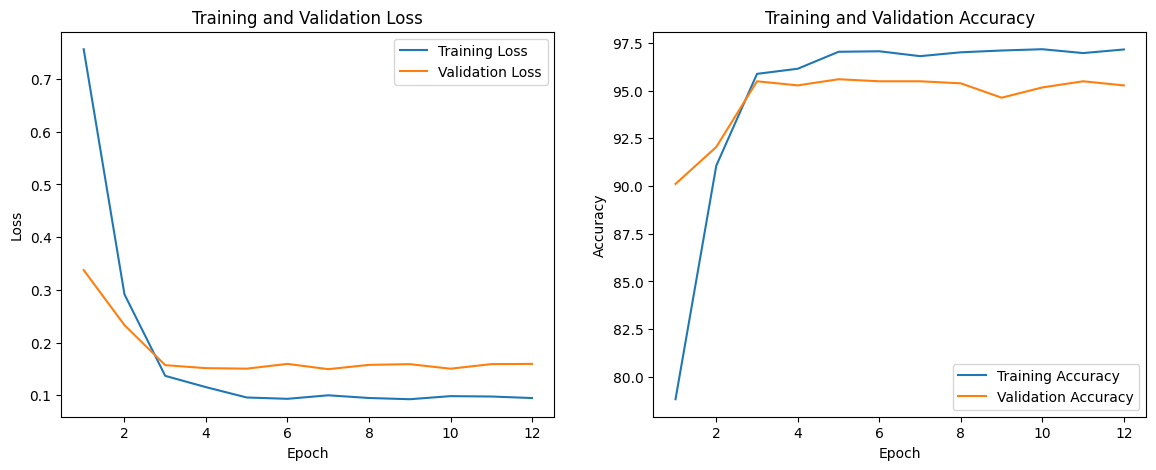

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = '/kaggle/working/runs/2024-04-20_00-33-07'
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

def extract_scalar(event_acc, tag):
    if tag in event_acc.Tags()['scalars']:
        return [scalar.value for scalar in event_acc.Scalars(tag)]
    else:
        return []

train_losses = extract_scalar(event_acc, 'Loss/Train')
train_accuracies = extract_scalar(event_acc, 'Accuracy/Train')
val_losses = extract_scalar(event_acc, 'Loss/Validation')
val_accuracies = extract_scalar(event_acc, 'Accuracy/Validation')
test_losses = extract_scalar(event_acc, 'Loss/Test')
test_accuracies = extract_scalar(event_acc, 'Accuracy/Test')
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
if test_losses:
    plt.axhline(y=test_losses[0], color='r', linestyle='-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
if test_accuracies:
    plt.axhline(y=test_accuracies[0], color='r', linestyle='-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 930 samples in 0.010s...
[t-SNE] Computed neighbors for 930 samples in 0.910s...
[t-SNE] Computed conditional probabilities for sample 930 / 930
[t-SNE] Mean sigma: 102.086689
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.910027
[t-SNE] KL divergence after 300 iterations: 2.185206


/tmp/ipykernel_33/3673495953.py:33: UserWarning: 
The palette list has fewer values (10) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels, legend='full', palette=sns.color_palette("hsv", 10))


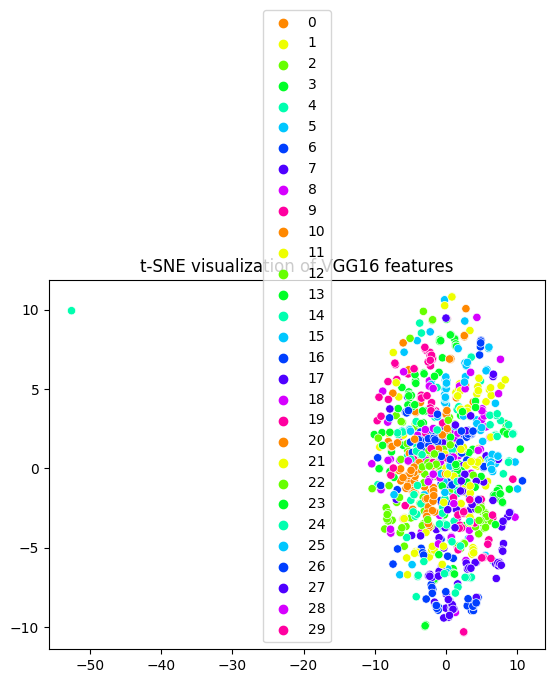

In [11]:
from sklearn.manifold import TSNE
class VGG16Features(nn.Module):
    def __init__(self, original_model):
        super(VGG16Features, self).__init__()
        self.features = nn.Sequential(*list(original_model.features.children()))
        self.avgpool = original_model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

vgg16_features = VGG16Features(vgg16).to(device)

def extract_features(data_loader, model):
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().detach().numpy())
            labels.extend(label.numpy())

    return np.array(features), np.array(labels)

features, labels = extract_features(validation_loader, vgg16_features)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels, legend='full', palette=sns.color_palette("hsv", 10))
plt.title('t-SNE visualization of VGG16 features')
plt.show()

Test Accuracy: 94.19%


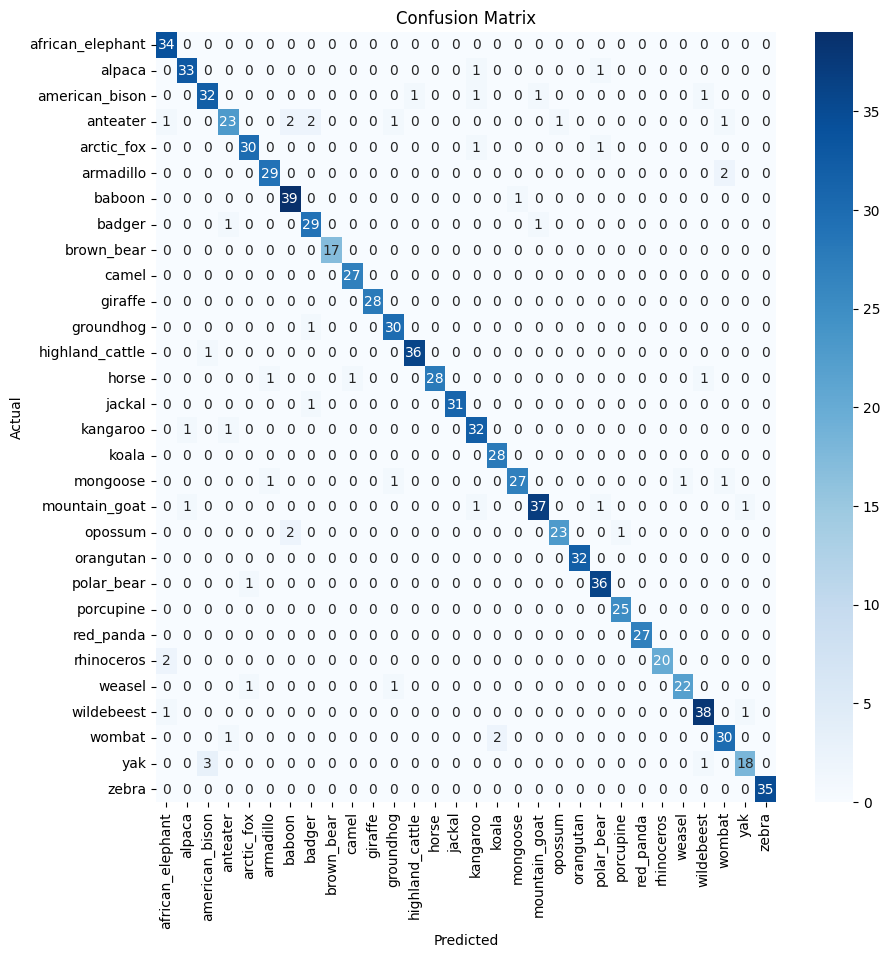

In [12]:
from sklearn.metrics import accuracy_score
vgg16.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\033[1mTest Accuracy: {accuracy * 100:.2f}%\033[0m")
conf_mat = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=full_dataset.classes, output_dict=True)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
     

In [13]:
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(true_labels, predicted_labels, target_names=full_dataset.classes))


Classification Report:
                  precision    recall  f1-score   support

african_elephant       0.89      1.00      0.94        34
          alpaca       0.94      0.94      0.94        35
  american_bison       0.89      0.89      0.89        36
        anteater       0.88      0.74      0.81        31
      arctic_fox       0.94      0.94      0.94        32
       armadillo       0.94      0.94      0.94        31
          baboon       0.91      0.97      0.94        40
          badger       0.88      0.94      0.91        31
      brown_bear       1.00      1.00      1.00        17
           camel       0.96      1.00      0.98        27
         giraffe       1.00      1.00      1.00        28
       groundhog       0.91      0.97      0.94        31
 highland_cattle       0.97      0.97      0.97        37
           horse       1.00      0.90      0.95        31
          jackal       1.00      0.97      0.98        32
        kangaroo       0.89      0.94      0.91

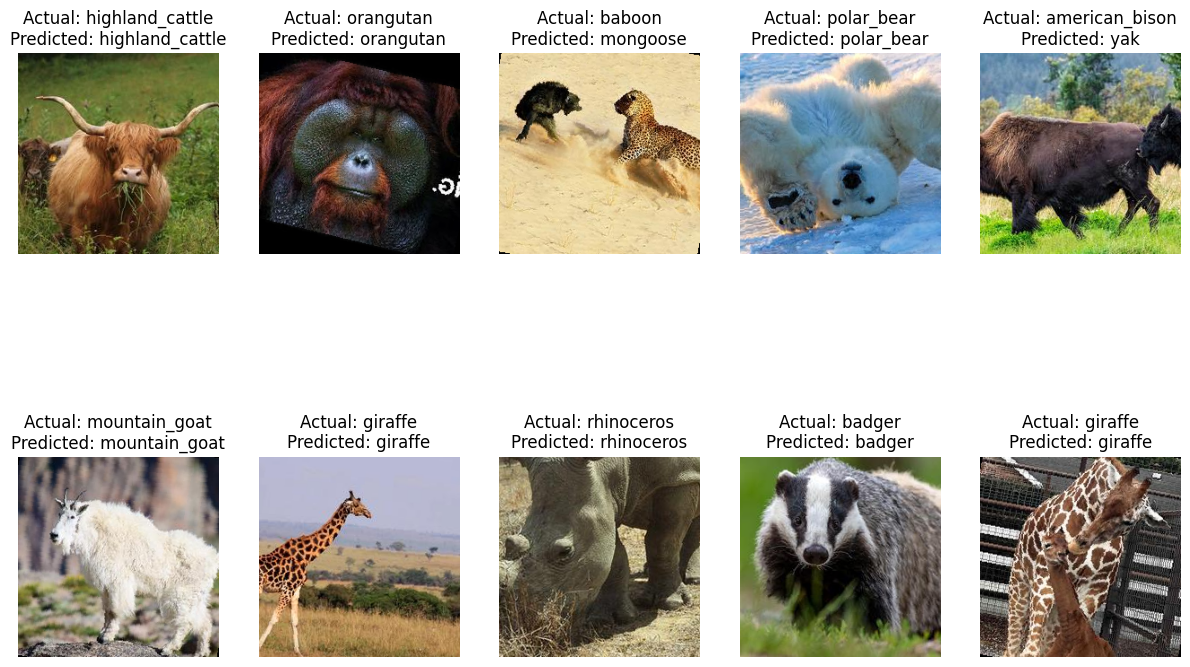

In [14]:
def imshow_with_labels(images, labels, predicted_labels):
    """Display images with labels."""
    fig, axs = plt.subplots(2, 5, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.1)
    axs = axs.flatten()
    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f'Actual: {full_dataset.classes[labels[i]]}\nPredicted: {predicted_labels[i]}')
        axs[i].axis('off')
    plt.show()
images, labels = next(iter(test_loader))
num_images = 10
images_to_show = images[:num_images]
labels_to_show = labels[:num_images]
images_to_show = images_to_show.to(device)
outputs = vgg16(images_to_show)
_, preds = torch.max(outputs, 1)
predicted_labels = [full_dataset.classes[pred] for pred in preds]
imshow_with_labels(images_to_show, labels_to_show, predicted_labels)